In [45]:
import ast
import numpy as np
import os
import pandas as pd
pd.set_option('display.precision', 3)
import matplotlib.pyplot as plt


In [46]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep=';', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.392,...,3.644,12.051,9.368e+09,9.496e+09,6.749e+09,6.906e+08,1.052e+09,7.479e+08,607.369,605.703
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.392,...,1.965,16.745,9.495e+09,9.632e+09,6.881e+09,-9.880e+07,1.539e+08,1.099e+08,605.807,610.678
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.392,...,-11.565,1.655,8.803e+09,8.529e+09,6.085e+09,9.138e+08,9.079e+08,6.478e+08,606.799,613.377
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.392,...,13.334,10.821,1.034e+10,9.569e+09,6.897e+09,3.470e+08,6.563e+08,4.730e+08,614.367,619.658
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.377,...,-4.236,6.160,9.598e+09,9.091e+09,6.605e+09,7.013e+08,6.893e+08,5.008e+08,621.915,625.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,173.8,157.6,154.4,174.0,169.0,153.6,191.1,156.7,163.4,1.251,...,2.787,26.525,6.262e+10,6.200e+10,4.911e+10,1.127e+09,3.766e+09,2.983e+09,4496.390,4557.690
2022-05-01,173.8,158.2,160.2,174.6,170.4,157.4,191.2,157.1,169.5,1.259,...,-1.985,17.067,6.350e+10,6.185e+10,4.813e+10,7.308e+09,6.083e+09,4.734e+09,4535.108,4581.210
2022-06-01,175.5,157.8,161.1,175.5,170.6,156.6,190.8,156.9,168.5,1.267,...,3.153,22.329,6.642e+10,6.362e+10,4.965e+10,4.702e+09,5.074e+09,3.960e+09,4581.997,4620.268
2022-07-01,178.7,159.4,160.1,177.3,172.1,156.5,192.0,158.2,169.8,1.292,...,-2.576,16.557,6.084e+10,6.259e+10,4.837e+10,5.144e+09,6.268e+09,4.844e+09,4603.726,4644.079


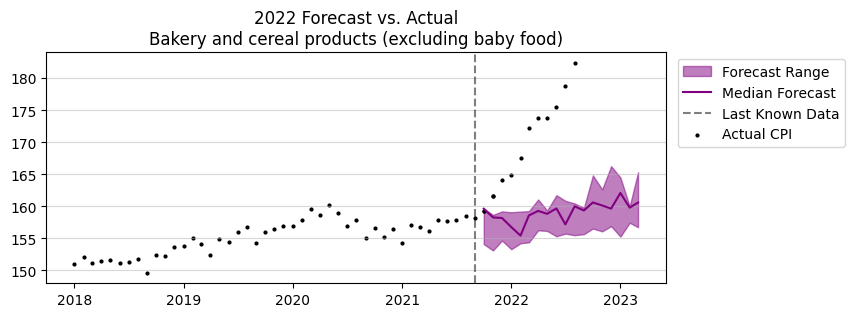

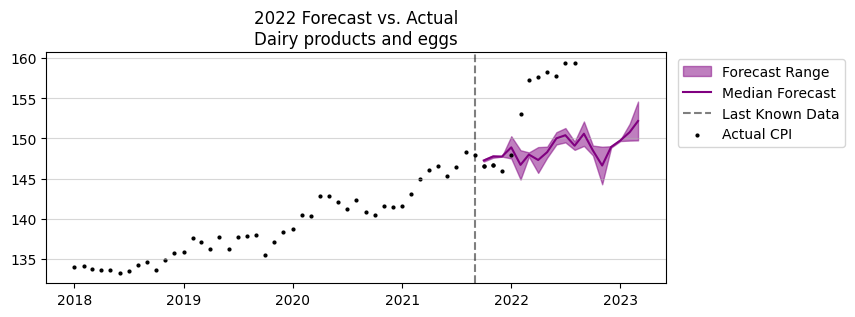

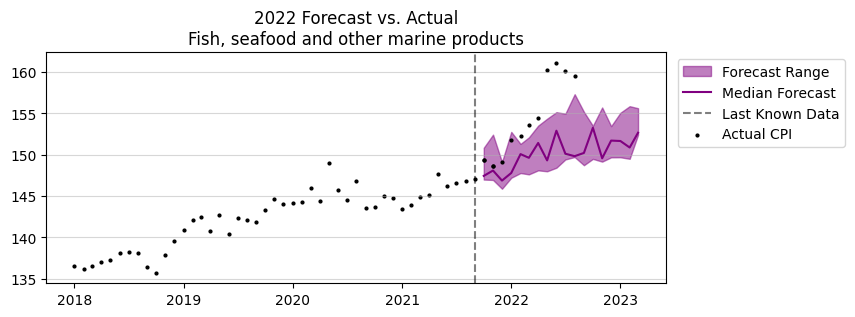

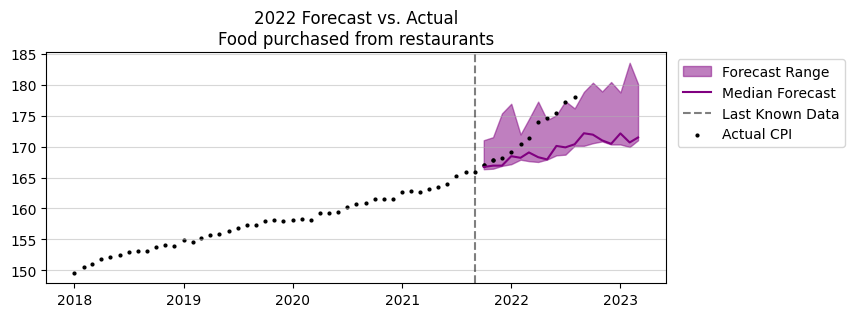

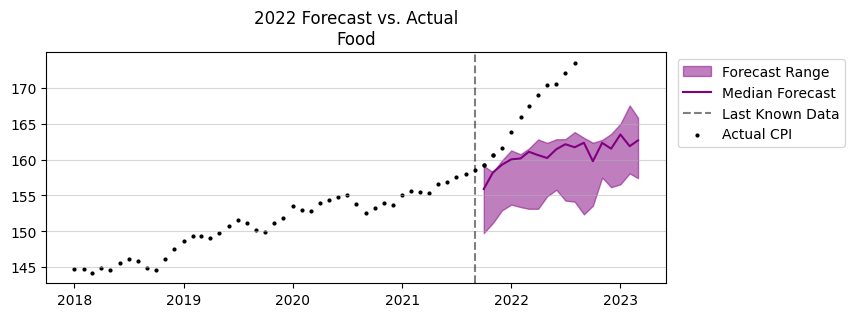

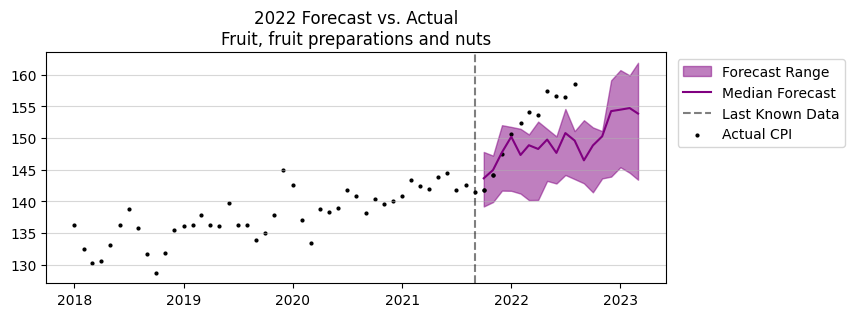

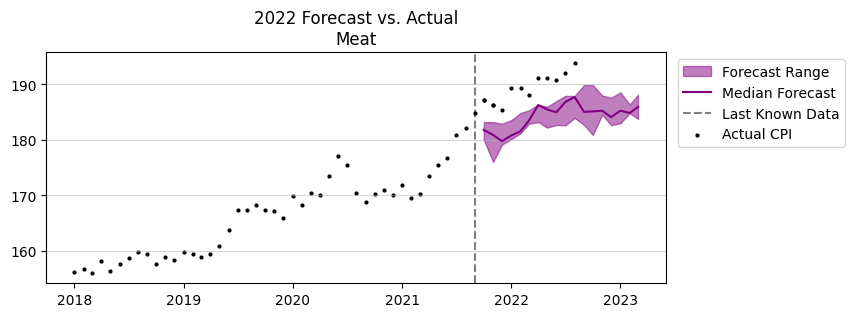

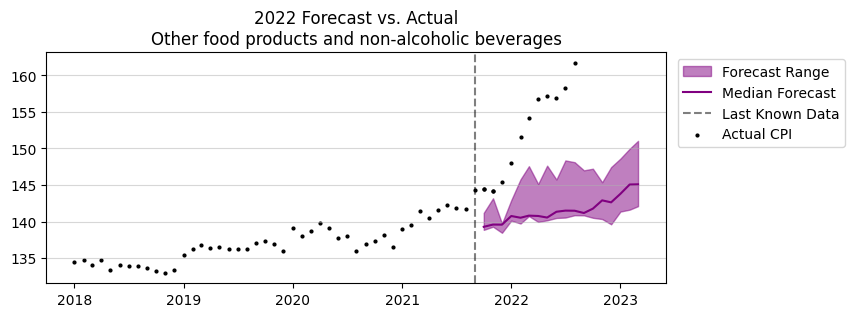

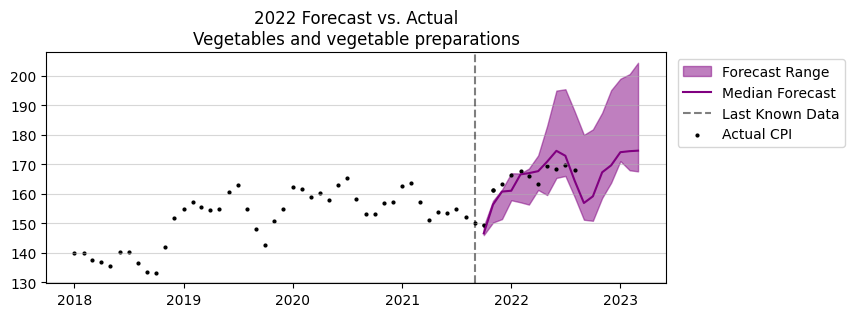

In [47]:
def load_final_forecast(category, experiment_name):
    base_dir = "./output"
    if experiment_name == "prophet_202110" or "nbeats" in experiment_name:
        forecast = pd.read_csv(f"{base_dir}/{experiment_name}/fc_final.csv", index_col=0)
    else:
        exp_name = experiment_name.replace("neuralprophet_202110_", "")
        final_forecast_dir = f"{category}_{exp_name}"
        forecast = pd.read_csv(f"{base_dir}/final_forecasts/{final_forecast_dir}/fc_final.csv", index_col=0)
    forecast = forecast.set_index(pd.DatetimeIndex(forecast.index))
    forecast = forecast[category]
    return forecast

results_file = open("./best_ensembles_2021.txt", 'r')
results_str = results_file.read()
results_dict = ast.literal_eval(results_str)
results_dict

median_forecasts = {}
forecast_index = None

for category in foodprice_categories:

    plt.figure(figsize=(8,3))

    # load each individual forecast
    fc_dirs = results_dict[category]
    
    forecasts = {}
    forecasts_list = []
    for exp_name in fc_dirs:
        forecast = load_final_forecast(category, exp_name)
        forecasts[exp_name] = forecast
        forecasts_list.append(forecast)
        # plt.plot(forecast.index, forecast, label=exp_name)

    forecast_med = np.median(forecasts_list, axis=0)
    forecast_min = np.min(forecasts_list, axis=0)
    forecast_max = np.max(forecasts_list, axis=0)

    # collect median forecasts
    median_forecasts[category] = forecast_med
    forecast_index = forecast.index

    plt.fill_between(forecast.index, forecast_min, forecast_max, color='purple', alpha=0.5, label='Forecast Range')
    plt.plot(forecast.index, forecast_med, color='purple', label='Median Forecast')

    actual = foodprice_df[category][foodprice_df.index >= "2021-10-01"]
    historical = foodprice_df[category][(foodprice_df.index >= "2018-01-01") & (foodprice_df.index < "2021-12-01")]
    plt.axvline(pd.to_datetime("2021-09-01"), color='black', alpha=0.5, ls='--', label="Last Known Data")
    plt.scatter(actual.index, actual, color='black', label="Actual CPI", s=4)
    plt.scatter(historical.index, historical, color='black', s=4)
    plt.title(f"2022 Forecast vs. Actual\n{category}")
    plt.legend(bbox_to_anchor=(1.3,1.0))
    # plt.xticks(forecast.index, rotation=45)
    plt.grid(axis='y', alpha=0.5)

    # break


In [48]:
# First 8 months of 2022
cpi_2022 = foodprice_df.loc[(foodprice_df.index >= "2022-01-01") & (foodprice_df.index <= "2022-08-01")].mean(axis=0)[foodprice_categories]
# First 8 months of 2021
cpi_2021 = foodprice_df.loc[(foodprice_df.index >= "2021-01-01") & (foodprice_df.index <= "2021-08-01")].mean(axis=0)[foodprice_categories]

In [49]:
# Percent change CPI first 8 months of 2021 vs. first 8 months of 2022

p1 = cpi_2021
p2 = cpi_2022

actual_pct_change = (((p2-p1) / p1) * 100)
actual_pct_change

Bakery and cereal products (excluding baby food)    10.564
Dairy products and eggs                              7.597
Fish, seafood and other marine products              7.591
Food purchased from restaurants                      6.169
Food                                                 8.197
Fruit, fruit preparations and nuts                   8.631
Meat                                                 8.956
Other food products and non-alcoholic beverages     10.329
Vegetables and vegetable preparations                7.246
dtype: float64

In [50]:
# First 8 months of median forecasts
forecast_df = pd.DataFrame(median_forecasts, index=forecast_index)
forecast_df = forecast_df.loc[(forecast_df.index >= "2022-01-01") & (forecast_df.index <= "2022-08-01")].mean(axis=0)[foodprice_categories]
forecast_df

Bakery and cereal products (excluding baby food)    158.196
Dairy products and eggs                             148.587
Fish, seafood and other marine products             150.114
Food purchased from restaurants                     169.047
Food                                                160.923
Fruit, fruit preparations and nuts                  149.042
Meat                                                184.634
Other food products and non-alcoholic beverages     140.964
Vegetables and vegetable preparations               168.167
dtype: float64

In [51]:
# Percent change CPI first 8 months of 2021 vs. first 8 months of 2022

p1 = cpi_2021
p2 = forecast_df

forecast_pct_change = (((p2-p1) / p1) * 100)
forecast_pct_change

Bakery and cereal products (excluding baby food)    0.746
Dairy products and eggs                             2.271
Fish, seafood and other marine products             3.127
Food purchased from restaurants                     3.251
Food                                                2.949
Fruit, fruit preparations and nuts                  4.481
Meat                                                5.490
Other food products and non-alcoholic beverages    -0.017
Vegetables and vegetable preparations               7.713
dtype: float64

In [52]:
result_df = pd.DataFrame({"Forecasted Percent Change": forecast_pct_change, "Actual Percent Change": actual_pct_change,})
result_df

,Forecasted Percent Change,Actual Percent Change
Bakery and cereal products (excluding baby food),0.746,10.564
Dairy products and eggs,2.271,7.597
"Fish, seafood and other marine products",3.127,7.591
Food purchased from restaurants,3.251,6.169
Food,2.949,8.197
"Fruit, fruit preparations and nuts",4.481,8.631
Meat,5.490,8.956
Other food products and non-alcoholic beverages,-0.017,10.329
Vegetables and vegetable preparations,7.713,7.246


In [54]:
# Difference between actual pct change and predicted pct change - basically WAY higher than predicted, except vegetables...
result_df["Actual Percent Change"] - result_df["Forecasted Percent Change"]

Bakery and cereal products (excluding baby food)     9.818
Dairy products and eggs                              5.326
Fish, seafood and other marine products              4.465
Food purchased from restaurants                      2.918
Food                                                 5.247
Fruit, fruit preparations and nuts                   4.150
Meat                                                 3.466
Other food products and non-alcoholic beverages     10.345
Vegetables and vegetable preparations               -0.467
dtype: float64

Text(0.5, 0, 'Year Over Year Percent Change')

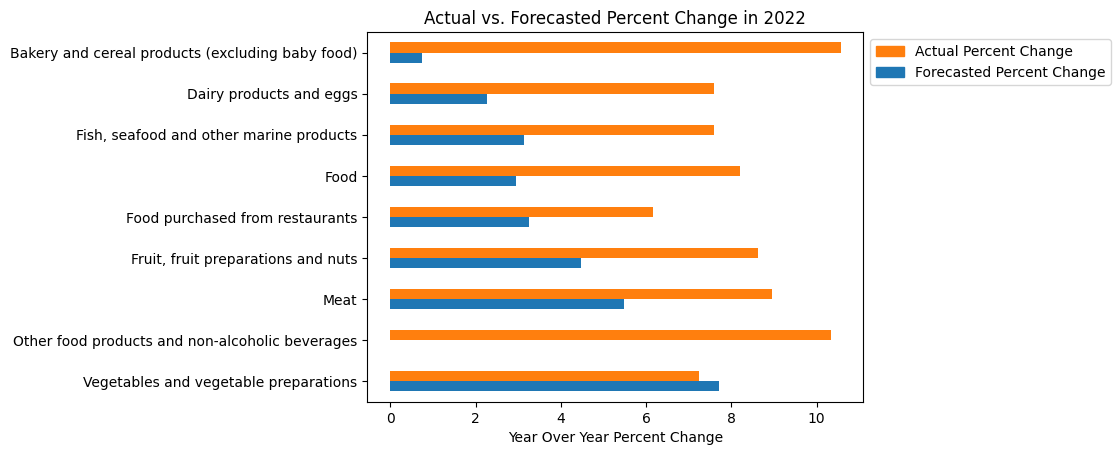

In [59]:
rename_dict = {
    "Bakery and cereal products (excluding baby food)": "Bakery",
    "Dairy products and eggs": "Dairy",
    "Fish, seafood and other marine products": "Seafood",
    "Food purchased from restaurants": "Restaurant"
}
fig = result_df.sort_index(ascending=False).plot(kind='barh', stacked=False)
plt.title("Actual vs. Forecasted Percent Change in 2022")

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='C1', label='Actual Percent Change')
blue_patch = mpatches.Patch(color='C0', label='Forecasted Percent Change')

plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1,1))
plt.xlabel('Year Over Year Percent Change')